In [2]:
import numpy as np

BAND_WIDTH = 4
DIAG = 1.2
BELOW_DIAG = 0.2
ABOVE_DIAG_NUM = 0.1
TWO_ABOVE_DIAG_NUM = 0.4 

In [3]:
# Function created just for validation purposes, later on 
def create_special_matrix(dimensions=5):
    ''' Creates special matrix and stores it in typical way - numpy array'''
    matrix = np.full((dimensions, dimensions), 0, dtype=float)
    for x in range(dimensions):
        for y in range(dimensions):
            if x == y:
                matrix[x][y] = DIAG
            elif x == y + 1:
                matrix[x][y] = BELOW_DIAG
            elif y == x + 1:
                matrix[x][y] = ABOVE_DIAG_NUM / (x+1)
            elif y == x + 2:
                matrix[x][y] = TWO_ABOVE_DIAG_NUM / (x+1)**2
    return matrix

create_special_matrix(dimensions=4)

array([[1.2       , 0.1       , 0.4       , 0.        ],
       [0.2       , 1.2       , 0.05      , 0.1       ],
       [0.        , 0.2       , 1.2       , 0.03333333],
       [0.        , 0.        , 0.2       , 1.2       ]])

In [4]:
# Function that allows to effectively store our rare matrix, it only stores 3 zero values
def smart_create_special_matrix(dimensions=5):
    ''' Stores the special matrix in smart way, storing only (almost only) non-zero values'''
    matrix = np.full(shape=(dimensions, BAND_WIDTH), fill_value=0, dtype=np.float64)
    for column in range(BAND_WIDTH):
        for row in range(dimensions):
            if column == BAND_WIDTH-4 and row != dimensions-1:
                matrix[row][column] = BELOW_DIAG
            elif column == BAND_WIDTH-3:
                matrix[row][column] = DIAG
            elif column == BAND_WIDTH-2 and row != dimensions-1:
                matrix[row][column] = ABOVE_DIAG_NUM / (row+1)
            elif column == BAND_WIDTH-1 and row != dimensions-1 and row != dimensions-2:
                matrix[row][column] = TWO_ABOVE_DIAG_NUM / (row+1)**2
                
    return matrix

smart_create_special_matrix(dimensions=4)

array([[0.2       , 1.2       , 0.1       , 0.4       ],
       [0.2       , 1.2       , 0.05      , 0.1       ],
       [0.2       , 1.2       , 0.03333333, 0.        ],
       [0.        , 1.2       , 0.        , 0.        ]])

In [5]:
# This function decomposes the band matrix, provided it is given in a format generated by previous function
def band_matrix_LU(band_matrix):
    ''' smart_stored_special_matrix -> such matrix LU decomposed, stored smartly as well'''
    band_matrix[0][0] = band_matrix[0][0]/band_matrix[0][1]
    for dimension in range(1, len(band_matrix)):
        band_matrix[dimension][1] = band_matrix[dimension][1] - band_matrix[dimension-1][0]*band_matrix[dimension-1][2]
        band_matrix[dimension][0] = band_matrix[dimension][0]/band_matrix[dimension][1]
        band_matrix[dimension][2] = band_matrix[dimension][2] - band_matrix[dimension-1][0]*band_matrix[dimension-1][3]
    return band_matrix

test = smart_create_special_matrix(dimensions=4)
band_matrix_LU(test)

array([[ 0.16666667,  1.2       ,  0.1       ,  0.4       ],
       [ 0.16901408,  1.18333333, -0.01666667,  0.1       ],
       [ 0.16627635,  1.2028169 ,  0.01643192,  0.        ],
       [ 0.        ,  1.19726776,  0.        ,  0.        ]])

In [6]:
def find_LU_determinant(band_matrix):
    ''' Requires SMART-STORED special matrix!'''
    result = 1.0
    for row in range(len(band_matrix)):
        result *= band_matrix[row][1]
    return result

test = band_matrix_LU(smart_create_special_matrix(dimensions=4))
find_LU_determinant(test) 

2.0449333333333333

In [7]:
# This function allows to solve linear equation LUy=x where LU and stored in a special way described previously

def solve_LU_eq(band_matrix, x=None):
    ''' LUy=x -> Lz=x & Uy=z, PASS x as A LIST'''
    DIMENSIONS = len(band_matrix)
    x = [i for i in range(1, DIMENSIONS+1)]
    
    def solve_for_z():
        ''' solves Lz=x and gives back z as a list'''
        result = [1]
        L_values = band_matrix[:, 0].tolist()[:-1] # I use list because L always produces one dimensional array
        L_values.insert(0, 0) # this is done only to make indexes between L and x match
        current_index = 1
        while len(result) != len(x):
            coord = x[current_index] - L_values[current_index]*result[-1]
            result.append(coord)
            current_index += 1
        return result
    
    z = solve_for_z()
    
    U_values = band_matrix[:,1:]
    # The first two y are solved by hand, because of zeroes at the bottom of smart storage
    result = [z[-1]/U_values[DIMENSIONS-1][0]]
    result.append((z[-2] - U_values[DIMENSIONS-2][1]*result[0]) / U_values[DIMENSIONS-2][0])
    
    already_solved_index = 0
    iteration = 2
    while len(result) != len(z):
        coord = (z[-(iteration+1)] - U_values[DIMENSIONS-iteration-1][2]*result[already_solved_index:iteration][0] - U_values[DIMENSIONS-iteration-1][1]*result[already_solved_index:iteration][1]) / U_values[DIMENSIONS-iteration-1][0]
        result.append(coord)
        already_solved_index +=1
        iteration += 1
    result.reverse()
    return result



In [8]:
# TESTING THE FUNCTIONS (IN COMPARISON TO BUILD-IN FUNCTIONS)
lib_matrix = create_special_matrix(100)
my_matrix = smart_create_special_matrix(100)
my_matrix = band_matrix_LU(my_matrix)

# Firstly, let's see whether the determinants match
lib_det = np.linalg.det(lib_matrix)
my_det = find_LU_determinant(my_matrix)
print(lib_det)
print(my_det)

78240161.0095941
78240161.00959387


In [9]:
# Now let's see whether y is calculated correctly
lib_matrix = create_special_matrix(100)
x = np.array([[x] for x in range(1, 101)])
my_matrix = smart_create_special_matrix(100)
my_matrix = band_matrix_LU(my_matrix)

lib_y = np.linalg.solve(lib_matrix, x)
my_y = solve_LU_eq(my_matrix)
print(lib_y.tolist(), end='\n\n')
print(my_y)
# In some cases they match up perfectly, in others we can see small diffrences at 10^-12 places or so

[[0.03287133486041395], [1.3396227980963753], [2.066480295894664], [2.8255436051753366], [3.557571715528883], [4.284492868897645], [5.00721018451999], [5.727664002754518], [6.446615582748809], [7.164554400995276], [7.881773878242026], [8.598465868371878], [9.314759799907842], [10.030746230199036], [10.74649032115277], [11.462040127963592], [12.177431844626687], [12.892693237901542], [13.60784595684208], [14.322907124390252], [15.037890457946187], [15.75280707355121], [16.467666073000725], [17.182474979167374], [17.897240063340146], [18.611966594532937], [19.32665903159678], [20.041321172855753], [20.755956273816835], [21.470567140615678], [22.185156204831525], [22.899725583859315], [23.61427712998635], [24.328812470561147], [25.0433330410833], [25.757840112626393], [26.472334814693667], [27.186818154368854], [27.901291032443737], [28.615754257064278], [29.33020855532933], [30.04465458319117], [30.75909293394065], [31.473524145507586], [32.1879487067645], [32.90236706298909], [33.616779

In [31]:
# CODE BELOW WAS USED TO GENERATE SOME PLOTS, THE ORDER MAY OF EXECUTION MAY NOT BE IN LINE WITH THE ORDER OF CELLS
from time import time

size_of_matrix = np.linspace(10**1, 10**3, num=100, dtype=int)
lib_time_per_matrix = []
for element in size_of_matrix:
    t0 = time()
    lib_matrix = create_special_matrix(element)
    x = np.array([[x] for x in range(1, element+1)])
    np.linalg.solve(lib_matrix, x)
    t1 = time()
    lib_time_per_matrix.append(t1-t0)
print(t1-t0)

0.18866944313049316


In [32]:
my_time_per_matrix = []

for element in size_of_matrix:
    t0 = time()
    my_matrix = smart_create_special_matrix(element)
    my_matrix = band_matrix_LU(my_matrix)
    solve_LU_eq(my_matrix)
    t1 = time()
    my_time_per_matrix.append(t1-t0)
print(t1-t0)

0.0


In [250]:
# Preparing data for plot

size_of_matrix = np.linspace(10**1, 10**4, num=100, dtype=int)
time_per_matrix = []
for element in size_of_matrix:
    t0 = time()
    my_matrix = smart_create_special_matrix(element)
    my_matrix = band_matrix_LU(my_matrix)
    solve_LU_eq(my_matrix)
    t1 = time()
    time_per_matrix.append(t1-t0)



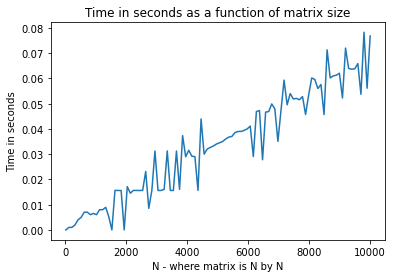

In [256]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('Time in seconds as a function of matrix size')
ax.set_xlabel('N - where matrix is N by N')
ax.set_ylabel('Time in seconds')
plt.plot(size_of_matrix, time_per_matrix);

# I have no idea how to interpret these irregularities other than the fact that it is Python. Nobody knows.

plt.savefig('line_plot.pdf')  

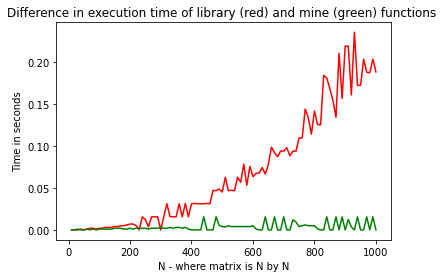

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title('Difference in execution time of library (red) and mine (green) functions ')
ax.set_xlabel('N - where matrix is N by N')
ax.set_ylabel('Time in seconds')
plt.plot(size_of_matrix, lib_time_per_matrix, color='red');
plt.plot(size_of_matrix, my_time_per_matrix, color='green');
plt.savefig('diff_plot.pdf') 